In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from datetime import datetime

import csv
from fog.tokenizers import WordTokenizer
import networkx as nx
from ipysigma import Sigma
from pelote import (
    graph_to_edges_dataframe,
    graph_to_nodes_dataframe,
    crop_to_largest_connected_component
)

import re
import math
from tqdm import tqdm
from collections import defaultdict, Counter

In [2]:
stop_list = ["'m", "'re", "'s", 'report', 'person', 'smh', 'it', 'great', 'there', 'days', 'hate', 'look', 'most', 'phone', 'well', 'watch', "'ve", 'm', 'by', 'cause', 'got', 'out', 'too', 'will', 't', 'get', 'video', 'keep', 'care', 'song', 'd', 'mean', 'night', 'was', 'he', 'miss', 'such', 'damn', 'is', 'house', 'a', 'into', 'am', 'been', 'im', 'much', 'one', 'just', 'are', 'really', 'sleep', 'team', 'want', 'work', 'photo', 'gotta', 'its', 'niggas', 'because', 'home', 'already', 'better', 'new', 'now', '3', 'off', 'made', 'over', 'your', 'only', 'tweet', 'week', 'she', 'this', 'didn', 'does', 'god', 'ever', 'dont', 'gonna', "i'", 'after', 'and', 'hard', 'help', 'how', 'in', 'their', 'any', 'him', 'bout', 'never', 'when', 'if', 'take', 'everyone', 'something', 'what', 'talk', "won't", 'they', 's', 'so', 'can', 'show', 'r', 'next', 'tell', 'them', 'guys', 'again', 'than', 'before', 'nigga', 'p', 'thing', 'g', 'w', 'friends', 'best', 'being', 'life', 'said', 'the', 'i', 'l', 'more', 'should', 'play', 'ross', 'someone', 'think', 'on', 'were', 'where', 'far', 'fuck', 'right', 'with', 'school', 'her', 'about', '2012', 'put', 'way', 'fucking', 'twitter', 'back', 'would', 'don', 'or', 'us', 'to', 'e', 'free', 'need', 'thank', 'who', '0', 'hip', 'every', 'gone', 'o', 'bad', 'head', 'at', 'ass', 'ready', 'day', 'll', 'heart', 'his', 'time', "'d", "'ll", 'my', 'f', 'all', 'has', 've', 'other', 'going', 'having', 'shit', 'an', 'go', 'wait', 'did', 'like', 'many', 'follow', 'last', 'morning', 'we', 'away', 'tomorrow', 'you', 'cool', 'no', 'that', 'feel', 'here', 'real', 'had', "don't", 'do', 're', 'live', "can't", 'news', 'lt', 'today', 'love', 'why', 'world', 'check', 'still', 'for', 'know', 'see', 'wish', 'have', 'cant', 'give', 'things', 'two', 'down', 'stop', 'say', 'class', 'done', 'thanks', 'looking', 'up', 'be', 'start', 'find', 'nothing', '1', 'tho', 'though', '2', 'won', 'another', 'hair', 'watching', 'please', 'make', 'then', 'even', 'people', 'let', 'year', 'everything', 'h', 'big', 'girls', 'wanna', 'could', 'from', 'our', 'ain', 'but', 'c', 'doing', 'hop', 'old', 'some', 'of', 'good', 'nice', 'n', 'b', 'as', 'money', 'girl', 'around', 'u', 'face', 'bitch', 'not', 'game', 'always', 'j', 'long', 'lmao', 'same', 'k', 'little', 'getting', 'win', 'these', 'hope', 'amp', 'tonight', 'man', 'come']
NUMBER_PARENTHESIS = re.compile("[0-9\(\)]")

tokenizer = WordTokenizer(lower=True, unidecode=True, drop=["punct", "number"], stoplist=stop_list)

report_class = {}

tokens = Counter()
tokens_per_report = defaultdict(set)
class_per_token = defaultdict(set)
idf = {}

with open("../data/bigfoot.csv", "r") as f:
    reader = csv.DictReader(f)
    for line in tqdm(reader, total=5021):
        report_class[line["number"]] = line["classification"]
        for _, token in tokenizer.tokenize(line["location_details"]):
            if not NUMBER_PARENTHESIS.search(token):
                tokens[token] += 1
                class_per_token[token].add(line["classification"])
                tokens_per_report[line["number"]].add(token)

100%|█████████████████████████████████████| 5021/5021 [00:00<00:00, 5309.87it/s]


In [3]:
for token in class_per_token.keys(): 
    idf[token] = math.log(5021 / len(class_per_token[token]))

In [4]:
dict_tokens = {k: v for k, v in tokens.most_common() if v > 5}
dict_tokens

{'road': 1741,
 'miles': 1054,
 'area': 801,
 'north': 746,
 'lake': 701,
 'south': 624,
 'river': 591,
 'near': 562,
 'west': 556,
 'east': 536,
 'rd': 514,
 'hwy': 513,
 'left': 486,
 'creek': 486,
 'mile': 477,
 'county': 476,
 'highway': 452,
 'turn': 431,
 'location': 414,
 'side': 410,
 'forest': 323,
 'state': 322,
 'park': 318,
 'trail': 318,
 'between': 279,
 'route': 234,
 'town': 228,
 'hill': 209,
 'mountain': 207,
 'bridge': 206,
 'woods': 203,
 'national': 190,
 'camp': 188,
 'very': 184,
 'which': 175,
 'past': 167,
 'small': 167,
 'end': 166,
 'sighting': 165,
 'dirt': 159,
 'along': 157,
 'campground': 154,
 'drive': 148,
 'onto': 139,
 'towards': 139,
 'located': 135,
 'directions': 134,
 'rt': 133,
 'first': 128,
 'exact': 125,
 'through': 125,
 'approximately': 124,
 'place': 124,
 'exit': 118,
 'heading': 118,
 'witness': 117,
 'incident': 114,
 'called': 114,
 'property': 113,
 'request': 112,
 'across': 111,
 'approx': 109,
 'mt': 108,
 'pass': 106,
 'fork': 104,

count    1151.000000
mean       35.750652
std        95.106053
min         6.000000
25%         8.000000
50%        13.000000
75%        27.500000
max      1741.000000
dtype: float64

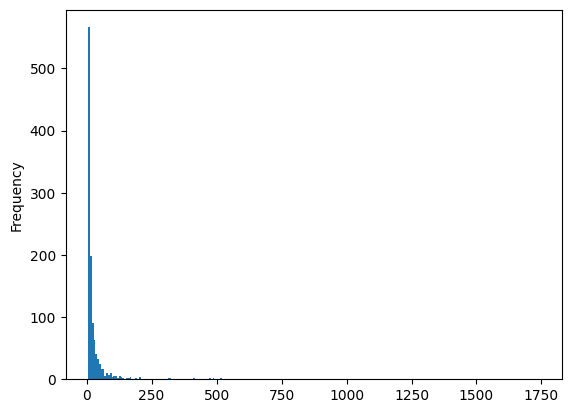

In [5]:
pd.Series(dict_tokens).plot.hist(bins = 250)
pd.Series(dict_tokens).describe()

In [6]:
g = nx.Graph()

for report, tokens_report in tokens_per_report.items():
    g.add_node(
        report,
        classification=report_class[report],
        part="report"
    )
    for token in tokens_report:
        if token in dict_tokens.keys():
            g.add_node(
                token,
                part="token"
            )
            g.add_edge(
                report,
                token
            )

print(g.order(), g.size(), nx.density(g))

crop_to_largest_connected_component(g)

Sigma(
    g,
    node_color="classification"
)

5390 35874 0.002470090416436147


Sigma(nx.Graph with 5,361 nodes and 35,874 edges)